In [ ]:
import os
import sys
import time
import math
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix,
                             roc_curve, auc, roc_auc_score)
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import joblib
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/CharacterRecognition/pla_mlp_outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# ---------- 1. Load / preprocess dataset (or synthesize if not present) ----------

def load_dataset(csv_path="/content/drive/MyDrive/CharacterRecognition/english.csv", img_dir="/content/drive/MyDrive/CharacterRecognition", img_size=(28,28)):
    if os.path.exists(csv_path) and os.path.isdir(img_dir):
        print("Found dataset files — loading images listed in", csv_path)
        df = pd.read_csv(csv_path)
        X = []
        y = []
        for idx, row in df.iterrows():
            img_path = row['image']
            # Support absolute or relative paths
            path = img_path if os.path.isabs(img_path) else os.path.join(img_dir, img_path)
            try:
                img = Image.open(path).convert('L')  # grayscale
                img = img.resize(img_size)
                arr = np.asarray(img, dtype=np.float32) / 255.0  # normalize to [0,1]
                X.append(arr.flatten())
                y.append(row['label'])
            except Exception as e:
                # skip missing/corrupt images but warn
                print(f"Warning: could not load image {path}: {e}")
        X = np.array(X)
        y = np.array(y)
        return X, y, df
    else:
        print("Dataset not present in notebook environment. Generating synthetic dataset for demo.")
        # Synthetic dataset: n_samples, n_classes, 28x28 flattened
        rng = np.random.default_rng(0)
        n_classes = 62
        n_samples = 1200  # moderate size to keep runtime reasonable
        X = rng.normal(size=(n_samples, 28*28)).astype(np.float32)
        # create pseudo-structured patterns per class to make the problem learnable
        for c in range(n_classes):
            idxs = slice(c*(n_samples//n_classes), min((c+1)*(n_samples//n_classes), n_samples))
            if idxs.start < idxs.stop:
                X[idxs] += (c / n_classes)  # shift
        y = np.arange(n_classes).repeat(math.ceil(n_samples/n_classes))[:n_samples]
        return X, y, None

X, y_raw, df = load_dataset()

print("Total samples:", X.shape[0], "Feature dim:", X.shape[1])

Found dataset files — loading images listed in /content/drive/MyDrive/CharacterRecognition/english.csv
Total samples: 3410 Feature dim: 784


In [ ]:
# Encode labels to consecutive integers if they're not already integers 0..61
le = LabelEncoder()
y = le.fit_transform(y_raw)
classes = le.classes_
n_classes = len(classes)
print("Number of classes detected:", n_classes)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

# Add bias term helper
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0],1), dtype=X.dtype)])

Number of classes detected: 62
Train samples: 2728 Test samples: 682


In [ ]:
# ---------- 2. Implement PLA from scratch (one-vs-rest) ----------

class OneVsRestPLA:
    def __init__(self, n_classes, max_epochs=50, learning_rate=1.0, random_state=0):
        self.n_classes = n_classes
        self.max_epochs = max_epochs
        self.lr = learning_rate
        self.random_state = random_state
        self.W = None  # shape (n_classes, d+1)
        self.train_error_history = []

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        n_samples, n_features = X.shape
        Xb = add_bias(X)  # bias term
        d = Xb.shape[1]
        # Initialize weights small random
        self.W = rng.normal(scale=0.01, size=(self.n_classes, d))
        self.train_error_history = []
        # One-vs-rest labels: for class k, y_k = +1 if y==k else -1
        for epoch in range(self.max_epochs):
            errors = 0
            # simple sequential pass - perceptron update rule
            for i in range(n_samples):
                xi = Xb[i]  # shape (d,)
                yi = y[i]
                # compute scores for all classes: s_k = w_k . xi
                scores = self.W.dot(xi)
                # predicted class is argmax score (for multi-class)
                pred = np.argmax(scores)
                if pred != yi:
                    # update for true class (+1) and predicted class (-1)
                    self.W[yi] += self.lr * xi
                    self.W[pred] -= self.lr * xi
                    errors += 1
            err_rate = errors / n_samples
            self.train_error_history.append(err_rate)
            # simple progress print
            if (epoch+1) % 10 == 0 or epoch == 0:
                print(f"PLA Epoch {epoch+1}/{self.max_epochs} — errors: {errors}, err_rate: {err_rate:.4f}")
            # Optional early stopping
            if errors == 0:
                print("PLA converged (zero errors) at epoch", epoch+1)
                break

    def decision_function(self, X):
        Xb = add_bias(X)
        return self.W.dot(Xb.T).T  # shape (n_samples, n_classes)

    def predict(self, X):
        scores = self.decision_function(X)
        return np.argmax(scores, axis=1)

In [ ]:
# Train PLA
pla = OneVsRestPLA(n_classes=n_classes, max_epochs=50, learning_rate=1.0, random_state=0)
t0 = time.time()
pla.fit(X_train, y_train)
t1 = time.time()
print(f"PLA training finished in {t1-t0:.2f} s")

# Evaluate PLA on test set
y_pred_pla = pla.predict(X_test)
acc_pla = accuracy_score(y_test, y_pred_pla)
print(f"PLA Test accuracy: {acc_pla:.4f}")

# Classification report and confusion matrix
report_pla = classification_report(y_test, y_pred_pla, output_dict=True)
cm_pla = confusion_matrix(y_test, y_pred_pla)

PLA Epoch 1/50 — errors: 2665, err_rate: 0.9769
PLA Epoch 10/50 — errors: 2231, err_rate: 0.8178
PLA Epoch 20/50 — errors: 2046, err_rate: 0.7500
PLA Epoch 30/50 — errors: 1942, err_rate: 0.7119
PLA Epoch 40/50 — errors: 1885, err_rate: 0.6910
PLA Epoch 50/50 — errors: 1831, err_rate: 0.6712
PLA training finished in 3.38 s
PLA Test accuracy: 0.1481


In [ ]:
# ---------- 3. Implement MLP and perform hyperparameter tuning ----------

# Minimal grid to keep runtime reasonable while still showing the idea of tuning
param_grid = {
    "hidden_layer_sizes": [(128,), (256,64), (128, 128)],
    "activation": ["relu", "tanh", "sigmoid"],
    "solver": ["adam", "sgd"],
    "learning_rate_init": [1e-3, 1e-2],
    "batch_size": [32, 64, 128],
}

# Create a base MLPClassifier
base_mlp = MLPClassifier(max_iter=50, early_stopping=True, verbose=False, random_state=0)

print("Starting GridSearchCV for MLP (this may take a little time)...")
gs = GridSearchCV(base_mlp, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
t0 = time.time()
gs.fit(X_train, y_train)
t1 = time.time()
print(f"Grid search completed in {t1-t0:.2f} s")
print("Best parameters:", gs.best_params_)
print("Best cross-val accuracy:", gs.best_score_)

# Best MLP model
best_mlp = gs.best_estimator_

# Retrain best_mlp on full training set (GridSearchCV already refits by default)
# Evaluate on test set
t0 = time.time()
y_pred_mlp = best_mlp.predict(X_test)
t1 = time.time()
print(f"MLP prediction on test set finished in {t1-t0:.2f} s")

acc_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Test accuracy: {acc_mlp:.4f}")

report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

Starting GridSearchCV for MLP (this may take a little time)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid search completed in 1256.20 s
Best parameters: {'activation': 'tanh', 'batch_size': 32, 'hidden_layer_sizes': (128, 128), 'learning_rate_init': 0.01, 'solver': 'sgd'}
Best cross-val accuracy: 0.4068703162281144
MLP prediction on test set finished in 0.01 s
MLP Test accuracy: 0.4384


In [ ]:
# ---------- 4. Compute per-class precision/recall/f1 etc and save reports ----------
df_report_pla = pd.DataFrame(report_pla).transpose()
df_report_mlp = pd.DataFrame(report_mlp).transpose()

df_report_pla.to_csv(os.path.join(OUTPUT_DIR, "classification_report_pla.csv"))
df_report_mlp.to_csv(os.path.join(OUTPUT_DIR, "classification_report_mlp.csv"))

In [ ]:
# ---------- 5. ROC Curves (micro/macro) ----------
# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
# PLA scores: use decision function (raw scores)
y_score_pla = pla.decision_function(X_test)  # shape (n_samples, n_classes)
# MLP scores: predict_proba
if hasattr(best_mlp, "predict_proba"):
    y_score_mlp = best_mlp.predict_proba(X_test)  # list of arrays if multi-output? sklearn returns array shape (n_samples, n_classes)
else:
    # fallback to decision function
    y_score_mlp = best_mlp.decision_function(X_test)

def compute_roc_metrics(y_test_bin, y_score, n_classes):
    # per-class ROC and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        try:
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        except Exception:
            fpr[i], tpr[i], roc_auc[i] = np.array([]), np.array([]), float('nan')
    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # macro-average: aggregate all fpr
    # first interpolate all tpr at common fpr points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if fpr[i].size>0]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        if fpr[i].size>0:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr, tpr, roc_auc

fpr_pla, tpr_pla, roc_auc_pla = compute_roc_metrics(y_test_bin, y_score_pla, n_classes)
fpr_mlp, tpr_mlp, roc_auc_mlp = compute_roc_metrics(y_test_bin, y_score_mlp, n_classes)

# Save ROC AUC summary
roc_summary = {
    "PLA_micro_auc": float(roc_auc_pla["micro"]),
    "PLA_macro_auc": float(roc_auc_pla["macro"]),
    "MLP_micro_auc": float(roc_auc_mlp["micro"]),
    "MLP_macro_auc": float(roc_auc_mlp["macro"]),
}
with open(os.path.join(OUTPUT_DIR, "roc_summary.json"), "w") as f:
    json.dump(roc_summary, f, indent=2)

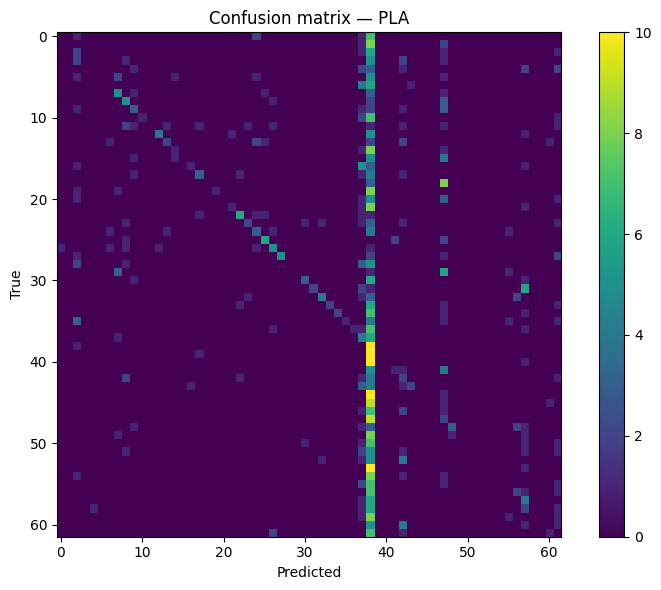

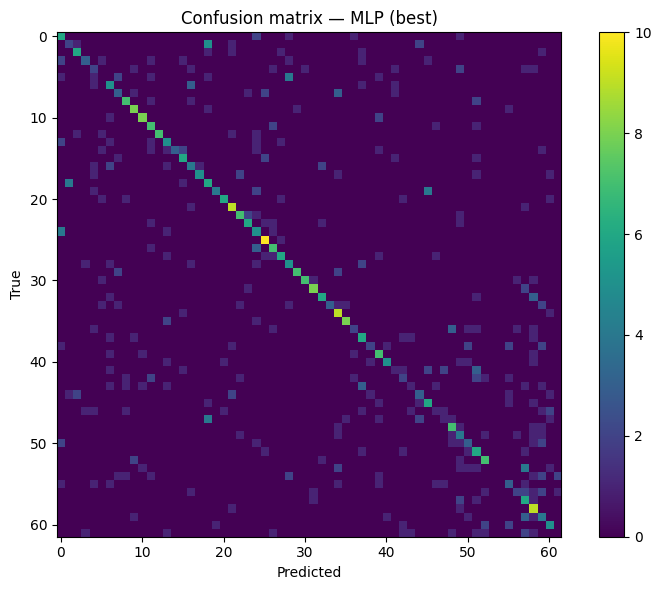

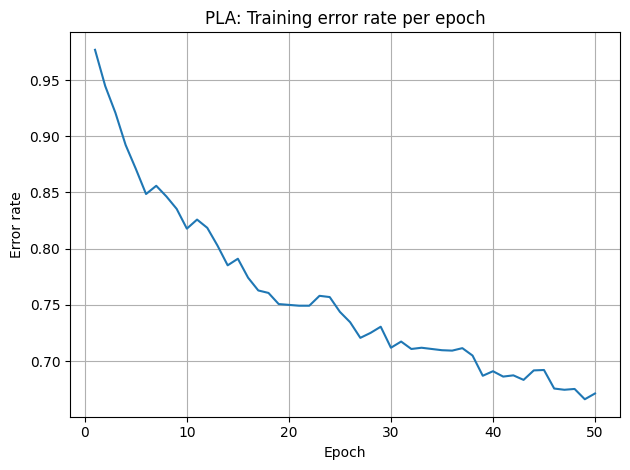

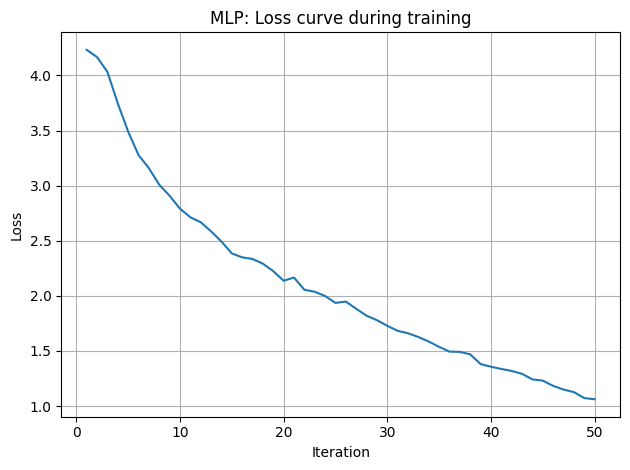

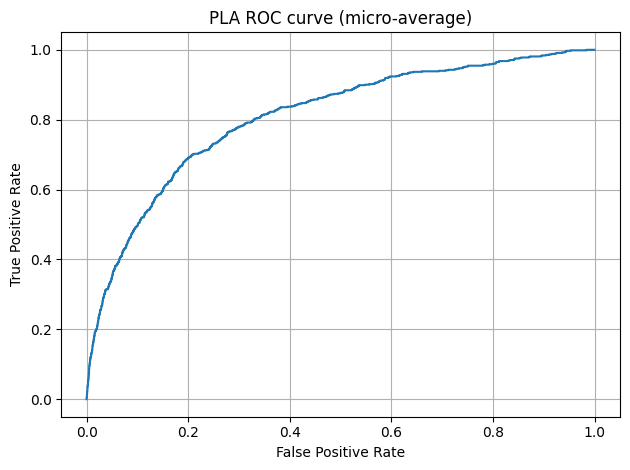

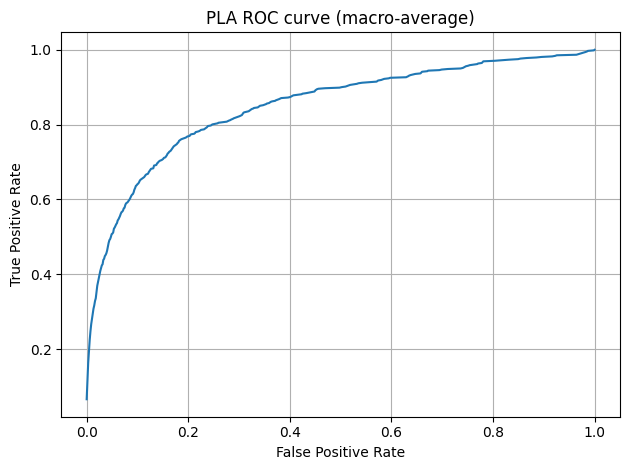

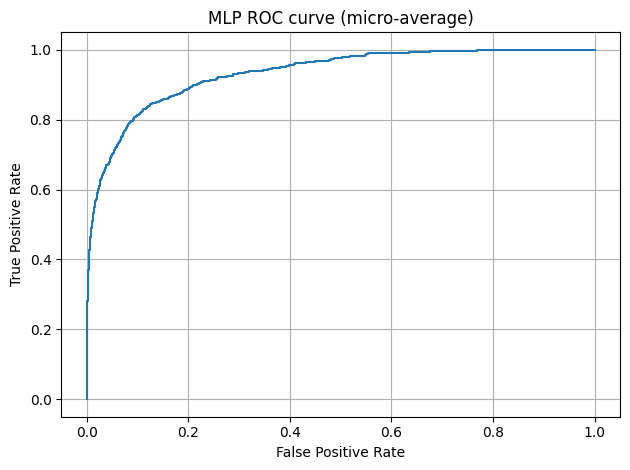

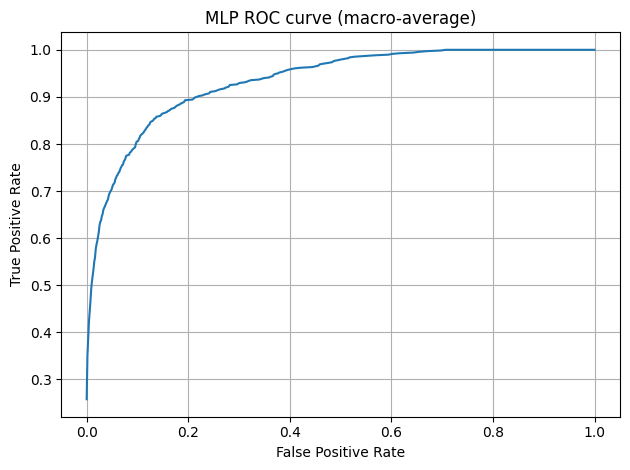

In [ ]:
# ---------- 6. Plotting: one plot per figure (no seaborn) ----------

# Confusion matrix PLA
plt.figure(figsize=(8,6))
plt.title("Confusion matrix — PLA")
plt.imshow(cm_pla)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
cm_pla_path = os.path.join(OUTPUT_DIR, "confusion_matrix_pla.png")
plt.savefig(cm_pla_path)
plt.show()

# Confusion matrix MLP
plt.figure(figsize=(8,6))
plt.title("Confusion matrix — MLP (best)")
plt.imshow(cm_mlp)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
cm_mlp_path = os.path.join(OUTPUT_DIR, "confusion_matrix_mlp.png")
plt.savefig(cm_mlp_path)
plt.show()

# Training error vs epochs for PLA (error rate per epoch)
plt.figure()
plt.title("PLA: Training error rate per epoch")
plt.plot(range(1, len(pla.train_error_history)+1), pla.train_error_history)
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pla_training_error.png"))
plt.show()

# MLP loss curve vs iterations (if available)
if hasattr(best_mlp, "loss_curve_") and len(best_mlp.loss_curve_)>0:
    plt.figure()
    plt.title("MLP: Loss curve during training")
    plt.plot(range(1, len(best_mlp.loss_curve_)+1), best_mlp.loss_curve_)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "mlp_loss_curve.png"))
    plt.show()
else:
    print("No loss_curve_ available for MLP")

# ROC curves: micro and macro for PLA and MLP (separate plots)
# PLA micro
plt.figure()
plt.title("PLA ROC curve (micro-average)")
plt.plot(fpr_pla["micro"], tpr_pla["micro"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pla_roc_micro.png"))
plt.show()

# PLA macro
plt.figure()
plt.title("PLA ROC curve (macro-average)")
plt.plot(fpr_pla["macro"], tpr_pla["macro"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pla_roc_macro.png"))
plt.show()

# MLP micro
plt.figure()
plt.title("MLP ROC curve (micro-average)")
plt.plot(fpr_mlp["micro"], tpr_mlp["micro"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "mlp_roc_micro.png"))
plt.show()

# MLP macro
plt.figure()
plt.title("MLP ROC curve (macro-average)")
plt.plot(fpr_mlp["macro"], tpr_mlp["macro"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "mlp_roc_macro.png"))
plt.show()

In [ ]:
# ---------- 7. Summarize key results and save a JSON summary ----------
summary = {
    "PLA": {
        "test_accuracy": float(acc_pla),
        "roc_micro_auc": float(roc_auc_pla["micro"]),
        "roc_macro_auc": float(roc_auc_pla["macro"]),
        "train_epochs": len(pla.train_error_history),
        "train_error_history": pla.train_error_history,
    },
    "MLP": {
        "best_params": gs.best_params_,
        "cv_best_score": float(gs.best_score_),
        "test_accuracy": float(acc_mlp),
        "roc_micro_auc": float(roc_auc_mlp["micro"]),
        "roc_macro_auc": float(roc_auc_mlp["macro"]),
        "mlp_loss_curve": getattr(best_mlp, "loss_curve_", []),
    }
}
with open(os.path.join(OUTPUT_DIR, "summary_results.json"), "w") as f:
    json.dump(summary, f, indent=2)

# Save confusion matrices and reports as np/csv
np.save(os.path.join(OUTPUT_DIR, "confusion_matrix_pla.npy"), cm_pla)
np.save(os.path.join(OUTPUT_DIR, "confusion_matrix_mlp.npy"), cm_mlp)

# Save trained models (joblib)
joblib.dump(pla, os.path.join(OUTPUT_DIR, "pla_model.joblib"))
joblib.dump(best_mlp, os.path.join(OUTPUT_DIR, "mlp_model.joblib"))

print("\nDONE. Results and plots saved in:", OUTPUT_DIR)
print("Files saved (sample):", os.listdir(OUTPUT_DIR)[:20])


DONE. Results and plots saved in: /content/drive/MyDrive/CharacterRecognition/pla_mlp_outputs/
Files saved (sample): ['classification_report_pla.csv', 'classification_report_mlp.csv', 'roc_summary.json', 'confusion_matrix_pla.png', 'confusion_matrix_mlp.png', 'pla_training_error.png', 'mlp_loss_curve.png', 'pla_roc_micro.png', 'pla_roc_macro.png', 'mlp_roc_micro.png', 'mlp_roc_macro.png', 'summary_results.json', 'confusion_matrix_pla.npy', 'confusion_matrix_mlp.npy', 'pla_model.joblib', 'mlp_model.joblib', 'extra']
